In [8]:
import zipfile
import os

# Define paths
zip_path = r"C:\Users\Admin\Desktop\CerebralFusion\Brain_Tumor_Dataset\brain_tumor.zip"
extract_path = r"C:\Users\Admin\Desktop\CerebralFusion\Brain_Tumor_Dataset"

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")


Extraction complete!


In [9]:
import os

# Define the dataset path
dataset_path = r"C:\Users\Admin\Desktop\CerebralFusion"

# Check if the path exists
if os.path.exists(dataset_path):
    print(f"Dataset directory found at: {dataset_path}")
else:
    print("Dataset directory not found. Please check the path.")


Dataset directory found at: C:\Users\Admin\Desktop\CerebralFusion


In [10]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the local base directory
base_dir = r"C:\Users\Admin\Desktop\CerebralFusion\Brain_Tumor_Dataset"
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Define paths for training, validation, and testing
train_dir = os.path.join(base_dir, 'Training')
val_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Testing')

# Ensure required directories exist
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

# Use ImageDataGenerator for loading and augmentation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

# Training dataset
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation dataset
val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Test dataset
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Print dataset statistics
print("Training images:", train_generator.samples)
print("Validation images:", val_generator.samples)
print("Testing images:", test_generator.samples)


Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Training images: 4857
Validation images: 855
Testing images: 1311


In [11]:
import numpy as np
import tensorflow as tf
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte
from skimage.color import rgb2gray

def preprocess_image(image):
    # Ensure image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)

    # Convert to grayscale if image is RGB
    if len(image.shape) == 3 and image.shape[-1] == 3:  # RGB check
        image = rgb2gray(image)

    # Apply OTSU thresholding
    thresh = threshold_otsu(image)
    binary = image > thresh
    binary = img_as_ubyte(binary)

    # Resize and normalize image
    image = tf.image.resize(image[..., np.newaxis], [224, 224])  # Keep single-channel shape
    image = image / 255.0  # Normalize

    return image.numpy()  # Convert TensorFlow tensor back to NumPy array


In [12]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Update dataset path
base_dir = r"C:\Users\Admin\Desktop\CerebralFusion\Brain_Tumor_Dataset"
train_dir = os.path.join(base_dir, "Training")

# Augmentation settings
datagen_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Load augmented training data
train_generator_aug = datagen_aug.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)


Found 5712 images belonging to 4 classes.


In [13]:
print("Training images:", train_generator_aug.samples)


Training images: 5712


In [ ]:
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import os


# # ✅ Define local paths
# base_dir = r"C:\Users\Admin\Desktop\CerebralFusion\Brain_Tumor_Dataset"
# train_dir = os.path.join(base_dir, "Training")
# val_dir = os.path.join(base_dir, "Validation")

# # ✅ Define model save path
# model_save_path = r"C:\Users\Admin\Desktop\CerebralFusion\vgg16_model.h5"

# # ✅ Ensure categories list is defined
# categories = ["glioma", "meningioma", "notumor", "pituitary"]

# # ✅ Data Augmentation
# datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.15)

# train_generator = datagen.flow_from_directory(
#     train_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", subset="training"
# )

# val_generator = datagen.flow_from_directory(
#     train_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", subset="validation"
# )

# # ✅ Load existing model if available
# if os.path.exists(model_save_path):
#     model_vgg = load_model(model_save_path)
#     print("✅ Model loaded from local directory.")
# else:
#     print("⚠️ No saved model found. Training a new model...")

#     # ✅ Load VGG16 without the top classification layer
#     base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

#     # ✅ Add custom layers on top
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)  # Reduce parameters, prevent overfitting
#     x = Dense(1024, activation="relu")(x)
#     predictions = Dense(len(categories), activation="softmax")(x)  # Match number of classes

#     # ✅ Define the full model
#     model_vgg = Model(inputs=base_model.input, outputs=predictions)

#     # ✅ Freeze base model layers (transfer learning)
#     for layer in base_model.layers:
#         layer.trainable = False

#     # ✅ Compile the model
#     model_vgg.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

#     # ✅ Train the model for 20 epochs
#     history_vgg = model_vgg.fit(train_generator, validation_data=val_generator, epochs=20)

#     # ✅ Save the trained model locally
#     model_vgg.save(model_save_path)
#     print("✅ Model trained and saved locally.")


Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.


TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

In [14]:
from tensorflow.keras.applications import VGG19 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define local paths
base_dir = r"C:\Users\Admin\Desktop\CerebralFusion\Brain_Tumor_Dataset"
train_dir = os.path.join(base_dir, "Training")
val_dir = os.path.join(base_dir, "Validation")

# Define model save path (changed to vgg19)
model_save_path = r"C:\Users\Admin\Desktop\CerebralFusion\vgg19_model.h5"  # Changed filename

# Ensure categories list is defined
categories = ["glioma", "meningioma", "notumor", "pituitary"]

# Data Augmentation
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.15)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", subset="training"
)

val_generator = datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", subset="validation"
)

# Load existing model if available
if os.path.exists(model_save_path):
    model_vgg = load_model(model_save_path)
    print("✅ VGG19 model loaded from local directory.")
else:
    print("⚠️ No saved model found. Training a new VGG19 model...")

    # Load VGG19 without the top classification layer 
    base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Reduce parameters, prevent overfitting
    x = Dense(1024, activation="relu")(x)
    predictions = Dense(len(categories), activation="softmax")(x)  # Match number of classes

    # Define the full model
    model_vgg = Model(inputs=base_model.input, outputs=predictions)

    # Freeze base model layers (transfer learning)
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model_vgg.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    # Train the model for 20 epochs
    history_vgg = model_vgg.fit(
        train_generator, 
        validation_data=val_generator, 
        epochs=20,
        verbose=1  # Show progress bar
    )

    # Save the trained model locally
    model_vgg.save(model_save_path)
    print(f"✅ VGG19 model trained and saved at {model_save_path}")

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.


✅ VGG19 model loaded from local directory.


In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# ✅ Define local paths
base_dir = r"C:\Users\Admin\Desktop\CerebralFusion\Brain_Tumor_Dataset"
train_dir = os.path.join(base_dir, "Training")
val_dir = os.path.join(base_dir, "Validation")

# ✅ Define model save path
model_save_path = r"C:\Users\Admin\Desktop\CerebralFusion\resnet50_model.h5"

# ✅ Ensure categories list is defined
categories = ["glioma", "meningioma", "notumor", "pituitary"]

# ✅ Data Augmentation
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.15)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", subset="training"
)

val_generator = datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", subset="validation"
)

# ✅ Load existing model if available
if os.path.exists(model_save_path):
    model_resnet = load_model(model_save_path)
    print("✅ ResNet50 model loaded from local directory.")
else:
    print("⚠️ No saved model found. Training a new ResNet50 model...")

    # ✅ Load ResNet50 without the top classification layer
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    # ✅ Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Reduce parameters, prevent overfitting
    x = Dense(1024, activation="relu")(x)
    predictions = Dense(len(categories), activation="softmax")(x)  # Match number of classes

    # ✅ Define the full model
    model_resnet = Model(inputs=base_model.input, outputs=predictions)

    # ✅ Freeze base model layers (transfer learning)
    for layer in base_model.layers:
        layer.trainable = False

    # ✅ Compile the model
    model_resnet.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    # ✅ Train the model for 20 epochs
    history_resnet = model_resnet.fit(train_generator, validation_data=val_generator, epochs=20)

    # ✅ Save the trained model locally
    model_resnet.save(model_save_path)
    print("✅ ResNet50 model trained and saved locally.")


Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.


✅ ResNet50 model loaded from local directory.


In [16]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# ✅ Define local paths
base_dir = r"C:\Users\Admin\Desktop\CerebralFusion\Brain_Tumor_Dataset"
train_dir = os.path.join(base_dir, "Training")
val_dir = os.path.join(base_dir, "Validation")

# ✅ Define model save path
model_save_path = r"C:\Users\Admin\Desktop\CerebralFusion\densenet121_model.h5"

# ✅ Ensure categories list is defined
categories = ["glioma", "meningioma", "notumor", "pituitary"]

# ✅ Data Augmentation
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.15)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", subset="training"
)

val_generator = datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", subset="validation"
)

# ✅ Load existing model if available
if os.path.exists(model_save_path):
    model_densenet = load_model(model_save_path)
    print("✅ DenseNet121 model loaded from local directory.")
else:
    print("⚠️ No saved model found. Training a new DenseNet121 model...")

    # ✅ Load DenseNet121 without the top classification layer
    base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    # ✅ Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Reduce parameters, prevent overfitting
    x = Dense(1024, activation="relu")(x)
    predictions = Dense(len(categories), activation="softmax")(x)  # Match number of classes

    # ✅ Define the full model
    model_densenet = Model(inputs=base_model.input, outputs=predictions)

    # ✅ Freeze base model layers (transfer learning)
    for layer in base_model.layers:
        layer.trainable = False

    # ✅ Compile the model
    model_densenet.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    # ✅ Train the model for 20 epochs
    history_densenet = model_densenet.fit(train_generator, validation_data=val_generator, epochs=20)

    # ✅ Save the trained model locally
    model_densenet.save(model_save_path)
    print("✅ DenseNet121 model trained and saved locally.")


Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.


✅ DenseNet121 model loaded from local directory.


In [17]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# ✅ Define local paths
base_dir = r"C:\Users\Admin\Desktop\CerebralFusion\Brain_Tumor_Dataset"
train_dir = os.path.join(base_dir, "Training")
val_dir = os.path.join(base_dir, "Validation")

# ✅ Define model save path
model_save_path = r"C:\Users\Admin\Desktop\CerebralFusion\custom_cnn_model.h5"

# ✅ Ensure categories list is defined
categories = ["glioma", "meningioma", "notumor", "pituitary"]

# ✅ Data Augmentation
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.15)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", subset="training"
)

val_generator = datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", subset="validation"
)

# ✅ Load existing model if available
if os.path.exists(model_save_path):
    model_custom = load_model(model_save_path)
    print("✅ Custom CNN model loaded from local directory.")
else:
    print("⚠️ No saved model found. Training a new Custom CNN model...")

    # ✅ Build the Custom CNN model
    model_custom = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),  
        MaxPooling2D((2, 2)),  
        Conv2D(64, (3, 3), activation="relu"),  
        MaxPooling2D((2, 2)),  
        Conv2D(128, (3, 3), activation="relu"),  
        MaxPooling2D((2, 2)),  
        Flatten(),  
        Dense(128, activation="relu"),  
        Dense(len(categories), activation="softmax")  
    ])

    # ✅ Compile the model
    model_custom.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    # ✅ Train the model for 20 epochs
    history_custom = model_custom.fit(train_generator, validation_data=val_generator, epochs=20)

    # ✅ Save the trained model locally
    model_custom.save(model_save_path)
    print("✅ Custom CNN model trained and saved locally.")


Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.


✅ Custom CNN model loaded from local directory.


In [18]:
import cv2
import numpy as np
import os
import joblib
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ✅ Define local paths
base_dir = r"C:\Users\Admin\Desktop\CerebralFusion\Brain_Tumor_Dataset"
train_dir = os.path.join(base_dir, "Training")

# ✅ Define model save path
model_save_path = r"C:\Users\Admin\Desktop\CerebralFusion\svm_model.pkl"

# ✅ Ensure categories list is defined
categories = ["glioma", "meningioma", "notumor", "pituitary"]

# ✅ Function to extract Gabor features
def extract_gabor_features(images):
    features = []
    kernels = []
    
    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for lamda in np.arange(0, np.pi, np.pi / 4):
                for gamma in (0.05, 0.5):
                    kernel = cv2.getGaborKernel((21, 21), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
                    kernels.append(kernel)

    for image in images:
        feature_vector = []
        for kernel in kernels:
            filtered = cv2.filter2D(image, cv2.CV_8UC3, kernel)
            feature_vector.append(filtered.mean())
        features.append(feature_vector)

    return np.array(features)

# ✅ Check if model exists
if os.path.exists(model_save_path):
    svm_model = joblib.load(model_save_path)
    print("✅ SVM model loaded from local directory.")
else:
    print("⚠️ No saved model found. Training a new SVM model...")

    # ✅ Load images and labels
    images, labels = [], []
    
    for category in categories:
        category_dir = os.path.join(train_dir, category)
        
        for img_name in os.listdir(category_dir):
            img_path = os.path.join(category_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (224, 224))
            images.append(img)
            labels.append(categories.index(category))

    # ✅ Extract Gabor features
    X = extract_gabor_features(images)
    y = np.array(labels)

    # ✅ Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # ✅ Train SVM classifier
    svm_model = SVC(kernel="linear", probability=True)
    svm_model.fit(X_train, y_train)

    # ✅ Save the trained model locally
    joblib.dump(svm_model, model_save_path)
    print("✅ SVM model trained and saved locally.")

# ✅ Evaluate SVM model
# y_pred = svm_model.predict(X_val)
# print(f"✅ SVM Accuracy: {accuracy_score(y_val, y_pred):.4f}")




✅ SVM model loaded from local directory.


In [19]:
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
import numpy as np
import cv2
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ✅ Define local paths
base_dir = r"C:\Users\Admin\Desktop\CerebralFusion\Brain_Tumor_Dataset"
train_dir = os.path.join(base_dir, "Training")

# ✅ Define model save path
model_save_path = r"C:\Users\Admin\Desktop\CerebralFusion\random_forest_model.pkl"

# ✅ Ensure categories list is defined
categories = ["glioma", "meningioma", "notumor", "pituitary"]

# ✅ Function to extract HOG features
def extract_hog_features(images):
    features = []
    
    for image in images:
        # Convert RGB to grayscale if necessary
        if len(image.shape) == 3 and image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Extract HOG features
        fd = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                 visualize=False, channel_axis=None)
        features.append(fd)
    
    return np.array(features)

# ✅ Check if model exists
if os.path.exists(model_save_path):
    rf_model = joblib.load(model_save_path)
    print("✅ Random Forest model loaded from local directory.")
else:
    print("⚠️ No saved model found. Training a new Random Forest model...")

    # ✅ Load images and labels
    images, labels = [], []
    
    for category in categories:
        category_dir = os.path.join(train_dir, category)
        
        for img_name in os.listdir(category_dir):
            img_path = os.path.join(category_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (224, 224))
            images.append(img)
            labels.append(categories.index(category))

    # ✅ Extract HOG features
    X_hog = extract_hog_features(images)
    y = np.array(labels)

    # ✅ Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_hog, y, test_size=0.2, random_state=42)

    # ✅ Train Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # ✅ Save the trained model locally
    joblib.dump(rf_model, model_save_path)
    print("✅ Random Forest model trained and saved locally.")

# ✅ Evaluate Random Forest model
# y_pred = rf_model.predict(X_val)
# print(f"✅ Random Forest Accuracy: {accuracy_score(y_val, y_pred):.4f}")


✅ Random Forest model loaded from local directory.


In [ ]:
# import numpy as np
# import pandas as pd
# import cv2
# from tensorflow.keras.models import load_model
# from joblib import load  # Use joblib for .pkl models
# from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# # Load deep learning models
# model_vgg = load_model("vgg19_model.h5")
# model_vgg.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# model_resnet = load_model("resnet50_model.h5")
# model_resnet.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# model_densenet = load_model("densenet121_model.h5")
# model_densenet.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# model_custom = load_model("custom_cnn_model.h5")
# model_custom.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# # Load machine learning models using joblib
# svm_model = load("svm_model.pkl")
# rf_model = load("random_forest_model.pkl")

# # Function to evaluate a model
# def evaluate_model(model, X_val, y_val, is_deep_learning=False):
#     if is_deep_learning:
#         y_pred_proba = model.predict(X_val)
#         y_pred = np.argmax(y_pred_proba, axis=1)
#         y_val = np.argmax(y_val, axis=1)  # Convert one-hot to integer labels
#     else:
#         y_pred = model.predict(X_val)
#         y_pred_proba = model.predict_proba(X_val)

#     accuracy = accuracy_score(y_val, y_pred)
#     f1 = f1_score(y_val, y_pred, average='weighted')

#     # Handle AUC-ROC correctly for multi-class classification
#     if len(np.unique(y_val)) > 2:  # Multi-class case
#         auc_roc = roc_auc_score(y_val, y_pred_proba, multi_class='ovr')
#     else:  # Binary case
#         auc_roc = roc_auc_score(y_val, y_pred_proba[:, 1])

#     return accuracy, f1, auc_roc

# # Dictionary to store models
# models = {
#     'VGG19': model_vgg,
#     'ResNet50': model_resnet,
#     'DenseNet': model_densenet,
#     'CNN': model_custom,
#     'SVM': svm_model,
#     'RandomForest': rf_model
# }

# # Get the full validation data
# X_val_dl_full = []
# y_val_dl_full = []
# for i in range(len(val_generator)):
#     X_batch, y_batch = val_generator[i]
#     X_val_dl_full.append(X_batch)
#     y_val_dl_full.append(y_batch)
# X_val_dl_full = np.vstack(X_val_dl_full)
# y_val_dl_full = np.vstack(y_val_dl_full)

# # Convert images to grayscale for HOG feature extraction
# X_val_dl_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) if len(img.shape) == 3 else img for img in X_val_dl_full])

# # Extract features for SVM and Random Forest
# X_val_gabor = extract_gabor_features(X_val_dl_full)  # Gabor features for SVM
# X_val_hog = extract_hog_features(X_val_dl_gray)  # HOG features for Random Forest

# # Evaluate models
# results = {}
# for name, model in models.items():
#     if name in ['VGG19', 'ResNet50', 'DenseNet', 'CNN']:
#         accuracy, f1, auc_roc = evaluate_model(model, X_val_dl_full, y_val_dl_full, is_deep_learning=True)
#     else:
#         X_val_fe = X_val_gabor if name == 'SVM' else X_val_hog
#         accuracy, f1, auc_roc = evaluate_model(model, X_val_fe, np.argmax(y_val_dl_full, axis=1), is_deep_learning=False)

#     results[name] = {'Accuracy': accuracy, 'F1-Score': f1, 'AUC-ROC': auc_roc}

# # Convert results to DataFrame
# results_df = pd.DataFrame(results).T
# print("Model Performance:")
# print(results_df)

# # Select top 3 models
# results_df['Combined_Score'] = (results_df['Accuracy'] + results_df['F1-Score'] + results_df['AUC-ROC']) / 3
# top_3_models = results_df.nlargest(3, 'Combined_Score').index.tolist()
# print("\nTop 3 Models:", top_3_models)


27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 791ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 546ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Model Performance:
              Accuracy  F1-Score   AUC-ROC
VGG19         0.859649  0.857641  0.966334
ResNet50      0.742690  0.724384  0.910129
DenseNet      0.921637  0.921792  0.990932
CNN           0.826901  0.829412  0.947507
SVM           0.231579  0.087090  0.687983
RandomForest  0.923977  0.923955  0.990631

Top 3 Models: ['RandomForest', 'DenseNet', 'VGG19']


In [26]:
# top 3 models on test data

import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.models import load_model
from joblib import load  # Use joblib for .pkl models
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import os
from skimage.feature import hog

# Configuration
model_mapping = {
    'VGG19': 'vgg19_model.h5',
    'ResNet50': 'resnet50_model.h5',
    'DenseNet': 'densenet121_model.h5',
    'CNN': 'custom_cnn_model.h5',
    'SVM': 'svm_model.pkl',
    'RandomForest': 'random_forest_model.pkl'
}

class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
test_dir = r'C:\Users\Admin\Desktop\CerebralFusion\Brain_Tumor_Dataset\Testing'
model_dir = '.' # Assuming your model files are in the current directory, adjust if needed

# Load models
models = {}
for name, file in model_mapping.items():
    path = os.path.join(model_dir, file)
    try:
        if file.endswith('.h5'):
            models[name] = load_model(path)
        else:
            models[name] = load(path)
        print(f"Loaded {name} successfully")
    except Exception as e:
        print(f"Error loading {name}: {e}")

# Load test data
def load_test_data(test_dir, target_size=(224, 224)):
    X_test = []
    y_test = []
    for i, label in enumerate(class_labels):
        label_dir = os.path.join(test_dir, label)
        if not os.path.exists(label_dir):
            continue
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img_resized = cv2.resize(img, target_size)
                    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
                    img_normalized = img_rgb.astype('float32') / 255.0
                    X_test.append(img_normalized)
                    y_test.append(i)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    return np.array(X_test), np.array(y_test)

X_test_dl, y_test_int = load_test_data(test_dir)
y_test_onehot = pd.get_dummies(y_test_int).values

# Convert images to grayscale for HOG feature extraction
X_test_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) if len(img.shape) == 3 else img for img in X_test_dl])

# Function to extract HOG features (ensure this is defined as in your first code)
def extract_hog_features(image):
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    features = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False,
        feature_vector=True
    )
    return features

# Extract features for SVM and Random Forest (assuming extract_gabor_features is defined elsewhere)
def extract_gabor_features(images):
    features = []
    kernels = []
    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for lamda in np.arange(0, np.pi, np.pi / 4):
                for gamma in (0.05, 0.5):
                    kernel = cv2.getGaborKernel((21, 21), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
                    kernels.append(kernel)
    for image in images:
        feature_vector = []
        for kernel in kernels:
            filtered = cv2.filter2D(image, cv2.CV_8UC3, kernel)
            feature_vector.append(filtered.mean())
        features.append(feature_vector)
    return np.array(features)

X_test_gabor = extract_gabor_features(X_test_dl)
X_test_hog = np.array([extract_hog_features(img) for img in X_test_gray])

# Function to evaluate a model
def evaluate_model(model, X_test, y_test, is_deep_learning=False):
    if is_deep_learning:
        y_pred_proba = model.predict(X_test)
        y_pred = np.argmax(y_pred_proba, axis=1)
        y_true = np.argmax(y_test, axis=1)  # Convert one-hot to integer labels
    else:
        y_pred = model.predict(X_test)
        try:
            y_pred_proba = model.predict_proba(X_test)
        except AttributeError:
            # Some classifiers might not have predict_proba (e.g., linear SVM without probability=True)
            y_pred_proba = None
        y_true = y_test

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    auc_roc = np.nan
    if y_pred_proba is not None:
        if len(np.unique(y_true)) > 2:  # Multi-class case
            try:
                auc_roc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', labels=np.unique(y_true))
            except ValueError as e:
                print(f"Error calculating AUC-ROC for multi-class: {e}")
        elif y_pred_proba.shape[1] > 1:  # Binary case with probability scores
            auc_roc = roc_auc_score(y_true, y_pred_proba[:, 1])
        elif y_pred_proba.shape[1] == 1: # Binary case with single probability score
            auc_roc = roc_auc_score(y_true, y_pred_proba[:, 0])

    return accuracy, f1, auc_roc

# Evaluate models on the test data
results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    if name in ['VGG19', 'ResNet50', 'DenseNet', 'CNN']:
        accuracy, f1, auc_roc = evaluate_model(model, X_test_dl, y_test_onehot, is_deep_learning=True)
    elif name == 'SVM':
        accuracy, f1, auc_roc = evaluate_model(model, X_test_gabor, y_test_int, is_deep_learning=False)
    elif name == 'RandomForest':
        accuracy, f1, auc_roc = evaluate_model(model, X_test_hog, y_test_int, is_deep_learning=False)

    results[name] = {'Accuracy': accuracy, 'F1-Score': f1, 'AUC-ROC': auc_roc}
    print(f"{name}: Accuracy = {accuracy:.4f}, F1-Score = {f1:.4f}, AUC-ROC = {auc_roc:.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("\nModel Performance on Test Data:")
print(results_df)

# Select top 3 models based on a combined score
results_df['Combined_Score'] = (results_df['Accuracy'] + results_df['F1-Score'] + results_df['AUC-ROC']) / 3
top_3_models = results_df.nlargest(3, 'Combined_Score').index.tolist()
print("\nTop 3 Models on Test Data:", top_3_models)

Loaded VGG19 successfully


Loaded ResNet50 successfully


Loaded DenseNet successfully
Loaded CNN successfully
Loaded SVM successfully
Loaded RandomForest successfully

Evaluating VGG19...
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 768ms/step
VGG19: Accuracy = 0.8848, F1-Score = 0.8829, AUC-ROC = 0.9814

Evaluating ResNet50...
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 516ms/step
ResNet50: Accuracy = 0.7689, F1-Score = 0.7485, AUC-ROC = 0.9355

Evaluating DenseNet...
41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 650ms/step
DenseNet: Accuracy = 0.9481, F1-Score = 0.9478, AUC-ROC = 0.9943

Evaluating CNN...
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
CNN: Accuracy = 0.9603, F1-Score = 0.9600, AUC-ROC = 0.9927

Evaluating SVM...
SVM: Accuracy = 0.2288, F1-Score = 0.0852, AUC-ROC = 0.6468

Evaluating RandomForest...
RandomForest: Accuracy = 0.8940, F1-Score = 0.8924, AUC-ROC = 0.9805

Model Performance on Test Data:
              Accuracy  F1-Score   AUC-ROC
VGG19         0.884821  0.882901  0.981351
ResNet50      0.768879  0.748500  0.935512
DenseNet      0.948131  0.947838  0.994280
CNN

In [27]:
# Get predictions from top 3 models
y_preds = []

for model_name in top_3_models:
    model = models[model_name]
    
    if model_name in ['VGG19', 'ResNet50', 'DenseNet', 'CNN']:
        # For deep learning models, get softmax probabilities
        y_pred_proba = model.predict(X_val_dl_full)
    
    else:
        # For SVM and Random Forest, use extracted features
        X_val_fe = X_val_gabor if model_name == 'SVM' else X_val_hog
        y_pred_proba = model.predict_proba(X_val_fe)

    y_preds.append(y_pred_proba)

# Convert to NumPy array for further processing
y_preds = np.array(y_preds)  # Shape: (3, num_samples, num_classes)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 589ms/step


In [28]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Normalize weights based on Combined_Score
weights = results_df.loc[top_3_models, 'Combined_Score'].values
weights /= np.sum(weights)  # Ensure sum of weights is 1

# Perform weighted averaging
y_weighted_avg = np.tensordot(weights, y_preds, axes=(0, 0))  # Shape: (num_samples, num_classes)

# Get final class predictions
y_weighted_avg_classes = np.argmax(y_weighted_avg, axis=1)

# Evaluate the weighted averaging hybrid model
y_true = np.argmax(y_val_dl_full, axis=1)  # Convert one-hot to integer labels

accuracy_weighted = accuracy_score(y_true, y_weighted_avg_classes)
f1_weighted = f1_score(y_true, y_weighted_avg_classes, average='weighted')

# Handle AUC-ROC correctly for multi-class classification
auc_roc_weighted = roc_auc_score(y_true, y_weighted_avg, multi_class='ovr')

# Display results
print("\n🎯 Weighted Averaging Hybrid Model Performance:")
print(f"✅ Accuracy: {accuracy_weighted:.4f}")
print(f"✅ F1-Score: {f1_weighted:.4f}")
print(f"✅ AUC-ROC: {auc_roc_weighted:.4f}")



🎯 Weighted Averaging Hybrid Model Performance:
✅ Accuracy: 0.9228
✅ F1-Score: 0.9233
✅ AUC-ROC: 0.9913


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Convert validation labels to class indices
y_true = np.argmax(y_val_dl_full, axis=1)

# Stack predictions from top 3 models
X_stack = np.hstack(y_preds)  # Ensure (num_samples, num_classes * num_models) shape

# Standardize the stacked predictions (helps with Logistic Regression stability)
scaler = StandardScaler()
X_stack_scaled = scaler.fit_transform(X_stack)

# Train a meta-learner (Logistic Regression)
meta_learner = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs', random_state=42)
meta_learner.fit(X_stack_scaled, y_true)

# Evaluate stacking hybrid model
y_stack_pred = meta_learner.predict(X_stack_scaled)
y_stack_pred_proba = meta_learner.predict_proba(X_stack_scaled)

# Calculate performance metrics
accuracy_stack = accuracy_score(y_true, y_stack_pred)
f1_stack = f1_score(y_true, y_stack_pred, average='weighted')
auc_roc_stack = roc_auc_score(y_true, y_stack_pred_proba, multi_class='ovr')

# Display results
print("\n🚀 Stacking Hybrid Model Performance:")
print(f"✅ Accuracy: {accuracy_stack:.4f}")
print(f"✅ F1-Score: {f1_stack:.4f}")
print(f"✅ AUC-ROC: {auc_roc_stack:.4f}")


🚀 Stacking Hybrid Model Performance:
✅ Accuracy: 0.9637
✅ F1-Score: 0.9636
✅ AUC-ROC: 0.9975


c:\Users\Admin\Desktop\CerebralFusion\cerebralFusion_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [30]:
from scipy.stats import mode

# Majority voting
y_pred_classes = np.array([np.argmax(y_pred, axis=1) for y_pred in y_preds])  # Shape: (num_models, num_samples)

# ✅ Fix for SciPy 1.11+ (mode now returns a named tuple)
y_majority_vote = mode(y_pred_classes, axis=0, keepdims=True).mode.flatten()

# Compute average probability predictions for AUC-ROC
y_avg_proba = np.mean(y_preds, axis=0)  # Average probabilities across models

# ✅ Verify correct shapes
print("Shape of y_pred_classes:", y_pred_classes.shape)  # (num_models, num_samples)
print("Shape of y_avg_proba:", y_avg_proba.shape)  # (num_samples, num_classes)
print("Shape of y_val_dl_full:", y_val_dl_full.shape)  # (num_samples, num_classes)

# Convert validation labels to class indices
y_true = np.argmax(y_val_dl_full, axis=1)

# ✅ Evaluate majority voting hybrid model
accuracy_majority = accuracy_score(y_true, y_majority_vote)
f1_majority = f1_score(y_true, y_majority_vote, average='weighted')
auc_roc_majority = roc_auc_score(y_true, y_avg_proba, multi_class='ovr')

# ✅ Display results
print("\n🗳️ Majority Voting Hybrid Model Performance:")
print(f"✅ Accuracy: {accuracy_majority:.4f}")
print(f"✅ F1-Score: {f1_majority:.4f}")
print(f"✅ AUC-ROC: {auc_roc_majority:.4f}")


Shape of y_pred_classes: (3, 855)
Shape of y_avg_proba: (855, 4)
Shape of y_val_dl_full: (855, 4)

🗳️ Majority Voting Hybrid Model Performance:
✅ Accuracy: 0.9263
✅ F1-Score: 0.9265
✅ AUC-ROC: 0.9915


In [31]:
# 📊 Compare hybrid model results
hybrid_results = {
    'Weighted Averaging': {
        'Accuracy': accuracy_weighted,
        'F1-Score': f1_weighted,
        'AUC-ROC': auc_roc_weighted
    },
    'Stacking': {
        'Accuracy': accuracy_stack,
        'F1-Score': f1_stack,
        'AUC-ROC': auc_roc_stack
    },
    'Majority Voting': {
        'Accuracy': accuracy_majority,
        'F1-Score': f1_majority,
        'AUC-ROC': auc_roc_majority
    }
}

# ✅ Convert to DataFrame for easy visualization
hybrid_results_df = pd.DataFrame(hybrid_results).T

# ✅ Compute a Combined Score (mean of all metrics)
hybrid_results_df['Combined_Score'] = hybrid_results_df.mean(axis=1)

# ✅ Display results
print("\n📊 Hybrid Model Performance Comparison:")
print(hybrid_results_df.round(4))  # Round values for better readability

# ✅ Select the best hybrid model based on Combined Score
best_hybrid_model = hybrid_results_df['Combined_Score'].idxmax()
print("\n🏆 Best Hybrid Model:", best_hybrid_model)



📊 Hybrid Model Performance Comparison:
                    Accuracy  F1-Score  AUC-ROC  Combined_Score
Weighted Averaging    0.9228    0.9233   0.9913          0.9458
Stacking              0.9637    0.9636   0.9975          0.9749
Majority Voting       0.9263    0.9265   0.9915          0.9481

🏆 Best Hybrid Model: Stacking


In [32]:
import numpy as np
import pandas as pd
import os
import gc
import joblib
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from scipy.stats import mode
from tensorflow.keras.applications.vgg19 import preprocess_input

# 📁 Define the local directory for saving models
model_save_dir = r'C:\Users\Admin\Desktop\CerebralFusion'
os.makedirs(model_save_dir, exist_ok=True)

# 📌 Define best hybrid model
best_hybrid_model = 'Stacking'  # Change to 'Weighted Averaging' or 'Majority Voting' as needed

# 📌 Hybrid model path
hybrid_model_path = os.path.join(model_save_dir, f'{best_hybrid_model}_hybrid_model.pkl')

# ✅ Define training parameters
BATCH_SIZE = 32
EPOCHS = 20

# ✅ Function to collect full dataset
def collect_full_data(generator):
    X_full, y_full = [], []
    generator.reset()
    for i in range(len(generator)):
        X_batch, y_batch = generator[i]
        X_full.append(X_batch)
        y_full.append(y_batch)
    return np.vstack(X_full), np.vstack(y_full)

def get_predictions_in_batches(model, generator, is_deep_learning=False):
    y_pred_proba = []
    generator.reset()
    
    # Initialize feature extractor if needed
    if not is_deep_learning and 'VGG19' in models:
        feature_extractor = models['VGG19']
        print(f"Feature extractor output shape: {feature_extractor.output_shape}")
    
    for i in range(len(generator)):
        X_batch, _ = generator[i]

        if not is_deep_learning:
            X_batch = preprocess_input(X_batch.copy())  
            X_batch = feature_extractor.predict(X_batch)
            X_batch = X_batch.reshape(X_batch.shape[0], -1)

            # Ensure dimension match
            if X_batch.shape[1] > model.n_features_in_:
                X_batch = X_batch[:, :model.n_features_in_]  # truncate
            elif X_batch.shape[1] < model.n_features_in_:
                padding = np.zeros((X_batch.shape[0], model.n_features_in_ - X_batch.shape[1]))
                X_batch = np.hstack([X_batch, padding])

        # Get predictions
        if is_deep_learning:
            y_pred_proba_batch = model.predict(X_batch)
        else:
            y_pred_proba_batch = model.predict_proba(X_batch) if hasattr(model, 'predict_proba') else model.predict(X_batch)
            
        y_pred_proba.append(y_pred_proba_batch)
    
    return np.vstack(y_pred_proba)

# 🔍 Check if hybrid model exists
if os.path.exists(hybrid_model_path):
    print(f"✅ {best_hybrid_model} hybrid model already exists. Loading...")
    if best_hybrid_model == 'Stacking':
        meta_learner = joblib.load(hybrid_model_path)
else:
    print(f"🚀 {best_hybrid_model} hybrid model not found. Training...")

    if best_hybrid_model == 'Weighted Averaging':
        y_preds_test = [get_predictions_in_batches(models[model], test_generator, model in ['VGG19', 'ResNet50', 'DenseNet', 'CNN'])
                        for model in top_3_models]

        # 🔢 Weighted Averaging
        weights = results_df.loc[top_3_models, 'Combined_Score'].values
        weights /= weights.sum()
        y_weighted_avg_test = np.average(y_preds_test, axis=0, weights=weights)
        y_weighted_avg_classes_test = np.argmax(y_weighted_avg_test, axis=1)

        # 📊 Evaluate
        accuracy_test = accuracy_score(np.argmax(y_test_dl_full, axis=1), y_weighted_avg_classes_test)
        f1_test = f1_score(np.argmax(y_test_dl_full, axis=1), y_weighted_avg_classes_test, average='weighted')
        auc_roc_test = roc_auc_score(np.argmax(y_test_dl_full, axis=1), y_weighted_avg_test, multi_class='ovr')

        print("\n📊 Weighted Averaging Hybrid Model Performance:")
        print(f"Accuracy: {accuracy_test}, F1-Score: {f1_test}, AUC-ROC: {auc_roc_test}")

    elif best_hybrid_model == 'Stacking':
        # 🔄 Collect full dataset
        X_train_dl_full, y_train_dl_full = collect_full_data(train_generator_aug)

        # 🎯 Get training predictions from top 3 models
        y_preds_train = [get_predictions_in_batches(models[model], train_generator_aug, model in ['VGG19', 'ResNet50', 'DenseNet', 'CNN'])
                         for model in top_3_models]

        # 🔢 Stacked Input
        X_stack_train = np.hstack(y_preds_train)

        # 🏋️‍♂️ Train Meta-Learner
        meta_learner.fit(X_stack_train, np.argmax(y_train_dl_full, axis=1))

        # 💾 Save model
        joblib.dump(meta_learner, hybrid_model_path)
        print(f"✅ Stacking model saved at: {hybrid_model_path}")

        # 🗑️ Memory Cleanup
        del X_train_dl_full, y_train_dl_full, y_preds_train, X_stack_train
        gc.collect()

    elif best_hybrid_model == 'Majority Voting':
        y_preds_test = [get_predictions_in_batches(models[model], test_generator, model in ['VGG19', 'ResNet50', 'DenseNet', 'CNN'])
                        for model in top_3_models]

        # 🗳️ Majority Voting
        y_pred_classes_test = np.array([np.argmax(y_pred, axis=1) for y_pred in y_preds_test])
        y_majority_vote_test, _ = mode(y_pred_classes_test, axis=0)
        y_majority_vote_test = y_majority_vote_test.flatten()

        # 📊 Evaluate
        accuracy_test = accuracy_score(np.argmax(y_test_dl_full, axis=1), y_majority_vote_test)
        f1_test = f1_score(np.argmax(y_test_dl_full, axis=1), y_majority_vote_test, average='weighted')
        auc_roc_test = roc_auc_score(np.argmax(y_test_dl_full, axis=1), np.mean(y_preds_test, axis=0), multi_class='ovr')

        print("\n📊 Majority Voting Hybrid Model Performance:")
        print(f"Accuracy: {accuracy_test}, F1-Score: {f1_test}, AUC-ROC: {auc_roc_test}")

# ✅ Hybrid Model Completed
print("\n🚀 Hybrid model training & evaluation completed!")


🚀 Stacking hybrid model not found. Training...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114m

c:\Users\Admin\Desktop\CerebralFusion\cerebralFusion_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



🚀 Hybrid model training & evaluation completed!


In [33]:
import os
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

# 📁 Define the local directory for saving models
model_save_dir = r'C:\Users\Admin\Desktop\CerebralFusion'
os.makedirs(model_save_dir, exist_ok=True)

def save_models(best_hybrid_model, models, top_3_models, meta_learner=None):
    """
    Save models based on the hybrid approach used
    
    Parameters:
    - best_hybrid_model: str ('Weighted_Averaging', 'Stacking', or 'Majority_Voting')
    - models: dict of trained models
    - top_3_models: list of model names to save
    - meta_learner: only needed for Stacking approach
    """
    try:
        print(f"\nStarting model save process in: {model_save_dir}")
        
        if best_hybrid_model == 'Weighted_Averaging':
            print("💾 Saving Weighted Averaging models...")
            for model_name in top_3_models:
                save_single_model(models[model_name], model_name)
                
        elif best_hybrid_model == 'Stacking':
            print("💾 Saving Stacking models and meta-learner...")
            
            # Debug: Check meta-learner exists
            if meta_learner is None:
                raise ValueError("Meta-learner is None! Please provide a trained meta-learner for Stacking")
            print(f"Meta-learner type: {type(meta_learner)}")
            
            # First save base models
            for model_name in top_3_models:
                save_single_model(models[model_name], model_name)
                
            # Then save meta-learner
            meta_learner_path = os.path.join(model_save_dir, 'stacking_meta_learner.pkl')
            print(f"Attempting to save meta-learner to: {meta_learner_path}")
            
            joblib.dump(meta_learner, meta_learner_path)
            print(f"✅ Successfully saved meta-learner to {meta_learner_path}")
            
        elif best_hybrid_model == 'Majority_Voting':
            print("💾 Saving Majority Voting models...")
            for model_name in top_3_models:
                save_single_model(models[model_name], model_name)
                
        else:
            raise ValueError(f"Unknown hybrid model type: {best_hybrid_model}")
            
        print(f"\n✅ All models saved successfully in: {model_save_dir}")
        return True
        
    except Exception as e:
        print(f"\n❌ Error saving models: {str(e)}")
        import traceback
        traceback.print_exc()
        return False

def save_single_model(model, model_name):
    """Helper function to save individual models"""
    try:
        # Determine file extension
        is_dl_model = model_name in ['VGG19', 'ResNet50', 'DenseNet', 'CNN']
        ext = '.h5' if is_dl_model else '.pkl'
        model_path = os.path.join(model_save_dir, f'{model_name}_model{ext}')
        
        print(f"Attempting to save {model_name} to: {model_path}")
        
        # Save model
        if is_dl_model:
            model.save(model_path)
            print(f"✅ Saved {model_name} (Keras) to {model_path}")
        else:
            joblib.dump(model, model_path)
            print(f"✅ Saved {model_name} (Scikit-learn) to {model_path}")
            
        return model_path
    except Exception as e:
        print(f"❌ Failed to save {model_name}: {str(e)}")
        raise


In [53]:
import cv2
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from scipy.stats import mode
from google.colab import files
from skimage.feature import hog  # Import HOG feature extractor

def extract_hog_features(image):
    # Ensure the image is large enough for HOG feature extraction
    min_size = 16  # Minimum size required by HOG
    if image.shape[0] < min_size or image.shape[1] < min_size:
        # Resize the image to meet the minimum size requirement
        image = cv2.resize(image, (min_size, min_size))

    # Extract HOG features
    features = hog(
        image,
        orientations=9,  # Number of orientation bins
        pixels_per_cell=(8, 8),  # Size of a cell
        cells_per_block=(2, 2),  # Number of cells in each block
        block_norm='L2-Hys',  # Normalization method
        visualize=False,  # Do not return the HOG image
        feature_vector=True  # Return features as a 1D array
    )
    return features.reshape(1, -1)  # Reshape to match input format for classifiers

def predict_with_hybrid_model(image_path):
    # Load the image and preprocess it
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    img = cv2.resize(img, (224, 224))  # Resize to 224x224
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=-1)  # Add channel dimension (1 channel)
    img = np.repeat(img, 3, axis=-1)  # Convert to 3 channels (RGB)
    img = np.expand_dims(img, axis=0)  # Add batch dimension (1, 224, 224, 3)

    # Load the top 3 models
    top_models = {}
    for model_name in top_3_models:
        if model_name in ['VGG19', 'ResNet50', 'DenseNet', 'CNN']:
            top_models[model_name] = load_model(f'{model_name}_model.h5')
        else:
            top_models[model_name] = joblib.load(f'{model_name}_model.pkl')

    # Get predictions from the top 3 models
    y_preds = []
    for model_name, model in top_models.items():
        if model_name in ['VGG19', 'ResNet50', 'DenseNet', 'CNN']:
            y_pred_proba = model.predict(img)  # Predict using deep learning models
        else:
            if model_name == 'SVM':
                features = extract_gabor_features(img[0, :, :, 0])  # Extract features from grayscale
            else:
                features = extract_hog_features(img[0, :, :, 0])  # Extract features from grayscale
            y_pred_proba = model.predict_proba(features)
        y_preds.append(y_pred_proba)

    # Combine predictions based on the best hybrid model
    if best_hybrid_model == 'Weighted Averaging':
        weights = results_df.loc[top_3_models, 'Combined_Score'].values
        weights /= weights.sum()  # Normalize weights
        y_weighted_avg = np.average(y_preds, axis=0, weights=weights)
        final_pred = np.argmax(y_weighted_avg, axis=1)
    elif best_hybrid_model == 'Stacking':
        X_stack = np.hstack(y_preds)
        meta_learner = joblib.load('stacking_meta_learner.pkl')
        final_pred = meta_learner.predict(X_stack)
    elif best_hybrid_model == 'Majority Voting':
        y_pred_classes = np.array([np.argmax(y_pred, axis=1) for y_pred in y_preds])
        final_pred, _ = mode(y_pred_classes, axis=0)
        final_pred = final_pred.flatten()

    # Map prediction to class label
    class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
    return class_labels[final_pred[0]]

# Upload an image using Google Colab's file uploader
uploaded = files.upload()
image_path = next(iter(uploaded))

# Make a prediction
if image_path:
    prediction = predict_with_hybrid_model(image_path)
    print("Predicted Class:", prediction)
else:
    print("No image selected.")

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# import cv2
# import numpy as np
# import joblib
# from tensorflow.keras.models import load_model
# from sklearn.metrics import accuracy_score, classification_report
# from skimage.feature import hog
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression
# import os

# # Configuration
# model_mapping = {
#     'VGG16': 'vgg16_model.h5',
#     'DenseNet': 'densenet121_model.h5',
#     'RandomForest': 'random_forest_model.pkl'
# }

# class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# # Path configuration
# model_dir = r'C:\Users\Admin\Desktop\CerebralFusion'
# test_dir = r'C:\Users\Admin\Desktop\CerebralFusion\Brain_Tumor_Dataset\Testing'

# # Custom metric function to handle loading
# def custom_mse(y_true, y_pred):
#     from keras import backend as K
#     return K.mean(K.square(y_pred - y_true), axis=-1)

# # Load models with proper error handling
# print("Loading models...")
# models = {}
# loaded_models = {}

# for model_name, model_file in model_mapping.items():
#     model_path = os.path.join(model_dir, model_file)
#     try:
#         if model_path.endswith('.h5'):
#             model = load_model(model_path, custom_objects={'mse': custom_mse})
#             # Verify model input shape
#             if model_name == 'VGG16' and model.input_shape[1:] != (224, 224, 3):
#                 print(f"Warning: {model_name} has unexpected input shape {model.input_shape}")
#                 continue
#             loaded_models[model_name] = model
#         else:
#             loaded_models[model_name] = joblib.load(model_path)
#         print(f"Loaded {model_name} successfully")
#     except Exception as e:
#         print(f"Error loading {model_name}: {str(e)}")

# # Load test data with proper preprocessing
# def load_test_data(test_dir):
#     X_test = []
#     y_test = []
#     print("\nLoading test data...")
    
#     for class_idx, class_name in enumerate(class_labels):
#         class_dir = os.path.join(test_dir, class_name)
#         if not os.path.exists(class_dir):
#             continue
            
#         print(f"Loading {class_name} images...")
#         for img_file in os.listdir(class_dir):
#             img_path = os.path.join(class_dir, img_file)
#             try:
#                 img = cv2.imread(img_path)
#                 if img is None:
#                     continue
                    
#                 img = cv2.resize(img, (224, 224))
#                 img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
#                 img = img.astype(np.float32) / 255.0  # Normalize
                
#                 X_test.append(img)
#                 y_test.append(class_idx)
#             except Exception as e:
#                 print(f"Error loading {img_path}: {str(e)}")
    
#     return np.array(X_test), np.array(y_test)

# X_test, y_test = load_test_data(test_dir)
# print(f"\nLoaded {len(X_test)} test samples")

# # Feature extraction with proper checks
# def extract_hog_features(image):
#     if len(image.shape) > 2:
#         image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     if image.dtype != np.uint8:
#         image = (image * 255).astype(np.uint8)
#     features = hog(
#         image,
#         orientations=9,
#         pixels_per_cell=(8, 8),
#         cells_per_block=(2, 2),
#         block_norm='L2-Hys',
#         visualize=False,
#         feature_vector=True
#     )
#     return features

# # Evaluation functions with proper model handling
# def evaluate_individual_models(models, X_test, y_test):
#     results = {}
    
#     for model_name, model in models.items():
#         print(f"\nEvaluating {model_name}...")
#         y_pred = []
        
#         print(f"Predicting with {model_name}...")
#         for img in X_test:
#             try:
#                 if model_name in ['VGG16', 'DenseNet']:
#                     # Ensure proper input shape
#                     if model.input_shape[1:] != img.shape:
#                         img_reshaped = cv2.resize(img, (model.input_shape[2], model.input_shape[1]))
#                         img_reshaped = np.expand_dims(img_reshaped, axis=0)
#                     else:
#                         img_reshaped = np.expand_dims(img, axis=0)
#                     pred = model.predict(img_reshaped, verbose=0)
#                     y_pred.append(np.argmax(pred))
#                 else:  # RandomForest
#                     features = extract_hog_features(img)
#                     pred = model.predict([features])
#                     y_pred.append(pred[0])
#             except Exception as e:
#                 print(f"Prediction error with {model_name}: {str(e)}")
#                 y_pred.append(0)  # Default prediction
        
#         acc = accuracy_score(y_test, y_pred)
#         results[model_name] = {
#             'accuracy': acc,
#             'report': classification_report(y_test, y_pred, target_names=class_labels, zero_division=0)
#         }
#         print(f"{model_name} Accuracy: {acc:.4f}")
    
#     return results

# def evaluate_stacking_hybrid_model(models, X_test, y_test):
#     print("\nEvaluating Stacking Hybrid Model...")
#     meta_features = []
    
#     for img in X_test:
#         img_meta_features = []
#         for model_name, model in models.items():
#             try:
#                 if model_name in ['VGG16', 'DenseNet']:
#                     if model.input_shape[1:] != img.shape:
#                         img_reshaped = cv2.resize(img, (model.input_shape[2], model.input_shape[1]))
#                         img_reshaped = np.expand_dims(img_reshaped, axis=0)
#                     else:
#                         img_reshaped = np.expand_dims(img, axis=0)
#                     pred = model.predict(img_reshaped, verbose=0)
#                     img_meta_features.extend(pred[0])
#                 else:  # RandomForest
#                     features = extract_hog_features(img)
#                     pred = model.predict_proba([features])
#                     img_meta_features.extend(pred[0])
#             except Exception as e:
#                 print(f"Error creating meta-features: {str(e)}")
#                 img_meta_features.extend([1.0/len(class_labels)]*len(class_labels))
        
#         meta_features.append(img_meta_features)
    
#     meta_features = np.array(meta_features)
    
#     # Train stacking classifier
#     stacking_model = LogisticRegression(max_iter=1000)
#     stacking_model.fit(meta_features, y_test)
    
#     # Evaluate
#     y_pred = stacking_model.predict(meta_features)
#     acc = accuracy_score(y_test, y_pred)
    
#     results = {
#         'accuracy': acc,
#         'report': classification_report(y_test, y_pred, target_names=class_labels, zero_division=0)
#     }
#     print(f"Stacking Hybrid Model Accuracy: {acc:.4f}")
#     return results

# # Main execution
# if __name__ == "__main__":
#     # Run evaluations
#     print("\nStarting evaluations...")
#     individual_results = evaluate_individual_models(loaded_models, X_test, y_test)

#     # Only run stacking if we have at least 2 models
#     if len(loaded_models) >= 2:
#         stacking_results = evaluate_stacking_hybrid_model(loaded_models, X_test, y_test)
#     else:
#         print("\nNot enough models loaded for stacking (need at least 2)")
#         stacking_results = None

#     # Print summary
#     print("\n\n=== Evaluation Summary ===")
#     print("\nIndividual Models:")
#     for model_name in loaded_models.keys():
#         print(f"{model_name}: {individual_results[model_name]['accuracy']:.4f}")

#     if stacking_results:
#         print(f"\nStacking Hybrid Model: {stacking_results['accuracy']:.4f}")

#     # Save results
#     output_file = os.path.join(model_dir, 'model_evaluation_results.txt')
#     with open(output_file, 'w') as f:
#         f.write("=== Individual Model Results ===\n")
#         for model_name in loaded_models.keys():
#             f.write(f"\n{model_name} - Accuracy: {individual_results[model_name]['accuracy']:.4f}\n")
#             f.write(individual_results[model_name]['report'])
        
#         if stacking_results:
#             f.write("\n\n=== Stacking Hybrid Model Results ===\n")
#             f.write(f"\nAccuracy: {stacking_results['accuracy']:.4f}\n")
#             f.write(stacking_results['report'])

#     print(f"\nResults saved to {output_file}")

Loading models...


Loaded DenseNet successfully
Loaded RandomForest successfully

Loading test data...
Loading glioma images...
Loading meningioma images...
Loading notumor images...
Loading pituitary images...

Loaded 1311 test samples

Starting evaluations...

Evaluating DenseNet...
Predicting with DenseNet...
DenseNet Accuracy: 0.9481

Evaluating RandomForest...
Predicting with RandomForest...
RandomForest Accuracy: 0.8940

Evaluating Stacking Hybrid Model...
Stacking Hybrid Model Accuracy: 0.9603


=== Evaluation Summary ===

Individual Models:
DenseNet: 0.9481
RandomForest: 0.8940

Stacking Hybrid Model: 0.9603

Results saved to C:\Users\Admin\Desktop\CerebralFusion\model_evaluation_results.txt


In [40]:
import cv2
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
from sklearn.linear_model import LogisticRegression
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import pandas as pd

# Configuration
model_mapping = {
    'VGG19': 'vgg19_model.h5',
    'DenseNet': 'densenet121_model.h5',
    'CustomCNN': 'custom_cnn_model.h5',
    'ResNet50': 'resnet50_model.h5',
    'RandomForest': 'random_forest_model.pkl',
    'SVM': 'svm_model.pkl'
}

class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Path configuration
model_dir = r'C:\Users\Admin\Desktop\CerebralFusion'
test_dir = r'C:\Users\Admin\Desktop\CerebralFusion\Brain_Tumor_Dataset\Testing'
output_dir = r'C:\Users\Admin\Desktop\CerebralFusion\model_comparison_plots'
training_history_dir = r'C:\Users\Admin\Desktop\CerebralFusion\training_history' # Assuming you have these
os.makedirs(output_dir, exist_ok=True)
os.makedirs(training_history_dir, exist_ok=True)

# Custom metric function to handle loading
def custom_mse(y_true, y_pred):
    from keras import backend as K
    return K.mean(K.square(y_pred - y_true), axis=-1)

# Load models
print("Loading models...")
models = {}
loaded_models = {}

for model_name, model_file in model_mapping.items():
    model_path = os.path.join(model_dir, model_file)
    try:
        if model_path.endswith('.h5'):
            model = load_model(model_path, custom_objects={'mse': custom_mse})
            loaded_models[model_name] = model
        else:
            loaded_models[model_name] = joblib.load(model_path)
        print(f"Loaded {model_name} successfully")
    except Exception as e:
        print(f"Error loading {model_name}: {str(e)}")

# Load test data
def load_test_data(test_dir):
    X_test = []
    y_test = []
    print("\nLoading test data...")

    for class_idx, class_name in enumerate(class_labels):
        class_dir = os.path.join(test_dir, class_name)
        if not os.path.exists(class_dir):
            continue

        print(f"Loading {class_name} images...")
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue

                img = cv2.resize(img, (224, 224))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = img.astype(np.float32) / 255.0  # Normalize

                X_test.append(img)
                y_test.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {str(e)}")

    return np.array(X_test), np.array(y_test)

X_test, y_test = load_test_data(test_dir)
print(f"\nLoaded {len(X_test)} test samples")

# Feature extraction
def extract_hog_features(image):
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    features = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False,
        feature_vector=True
    )
    return features

# Evaluation functions
# Evaluation functions
def evaluate_individual_models(models, X_test, y_test):
    results = {}
    y_true = y_test

    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")
        y_pred = []

        print(f"Predicting with {model_name}...")
        for img in X_test:
            try:
                if model_name in ['VGG19', 'DenseNet', 'CustomCNN', 'ResNet50']:
                    img_reshaped = np.expand_dims(img, axis=0)
                    pred = model.predict(img_reshaped, verbose=0)
                    y_pred.append(np.argmax(pred))
                elif model_name == 'RandomForest':
                    features = extract_hog_features(img)
                    pred = model.predict([features])
                    y_pred.append(pred[0])
                elif model_name == 'SVM':
                    img_gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
                    # Apply the same resizing as during training
                    img_resized = cv2.resize(img_gray, (224, 224))
                    # Extract Gabor features (assuming you have this function defined or will define it)
                    gabor_features = extract_gabor_features([img_resized])
                    pred = model.predict(gabor_features)
                    y_pred.append(pred[0])
            except Exception as e:
                print(f"Prediction error with {model_name}: {str(e)}")
                y_pred.append(-1)  # Append a placeholder for error

        # Filter out error predictions for evaluation
        valid_preds = [p for p in y_pred if p != -1]
        valid_true = [y_true[i] for i, p in enumerate(y_pred) if p != -1]

        if valid_preds:
            # Calculate accuracy and F1-score
            acc = accuracy_score(valid_true, valid_preds)
            f1 = f1_score(valid_true, valid_preds, average='weighted')
            report = classification_report(valid_true, valid_preds, target_names=class_labels, zero_division=0)
            results[model_name] = {
                'accuracy': acc,
                'f1': f1,
                'y_pred': np.array(valid_preds),
                'y_true': np.array(valid_true),
                'report': report
            }
            print(f"{model_name} Accuracy: {acc:.4f}, F1-score: {f1:.4f}")
        else:
            print(f"No valid predictions for {model_name}.")
            results[model_name] = {'accuracy': 0.0, 'f1': 0.0, 'y_pred': np.array([]), 'y_true': np.array([]), 'report': ''}

    return results

# You need to define the extract_gabor_features function here,
# exactly as it was used during the SVM training.
def extract_gabor_features(images):
    features = []
    kernels = []

    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for lamda in np.arange(0, np.pi, np.pi / 4):
                for gamma in (0.05, 0.5):
                    kernel = cv2.getGaborKernel((21, 21), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
                    kernels.append(kernel)

    for image in images:
        feature_vector = []
        for kernel in kernels:
            filtered = cv2.filter2D(image, cv2.CV_8UC3, kernel)
            feature_vector.append(filtered.mean())
        features.append(feature_vector)

    return np.array(features)

# Modify the stacking hybrid model as well to use Gabor features for SVM
def evaluate_stacking_hybrid_model(models, top_model_names, X_test, y_test):
    print("\nEvaluating Stacking Hybrid Model (Top Models Only)...")
    meta_features = []

    for img in X_test:
        img_meta_features = []
        for model_name in top_model_names:
            if model_name in models:
                model = models[model_name]
                try:
                    if model_name in ['VGG19', 'DenseNet', 'CustomCNN', 'ResNet50']:
                        img_reshaped = np.expand_dims(img, axis=0)
                        pred = model.predict(img_reshaped, verbose=0)
                        img_meta_features.extend(pred[0])
                    elif model_name == 'RandomForest':
                        features = extract_hog_features(img)
                        pred = model.predict_proba([features])
                        img_meta_features.extend(pred[0])
                    elif model_name == 'SVM':
                        img_gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
                        img_resized = cv2.resize(img_gray, (224, 224))
                        gabor_features = extract_gabor_features([img_resized])
                        pred = model.predict_proba(gabor_features)
                        img_meta_features.extend(pred[0])
                except Exception as e:
                    print(f"Error creating meta-features for {model_name}: {str(e)}")
                    img_meta_features.extend([1.0/len(class_labels)]*len(class_labels))
            else:
                print(f"Warning: Top model '{model_name}' not found in loaded models.")
                img_meta_features.extend([1.0/len(class_labels)]*len(class_labels))

        meta_features.append(img_meta_features)

    meta_features = np.array(meta_features)

    # Train stacking classifier
    stacking_model = LogisticRegression(max_iter=1000)
    stacking_model.fit(meta_features, y_test)

    # Evaluate
    y_pred = stacking_model.predict(meta_features)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Plot confusion matrix for the stacking model
    plot_stacking_confusion_matrix(y_test, y_pred, model_name='Stacking Hybrid')

    results = {
        'accuracy': acc,
        'f1': f1,
        'y_pred': y_pred,
        'y_true': y_test,
        'report': classification_report(y_test, y_pred, target_names=class_labels, zero_division=0)
    }
    print(f"Stacking Hybrid Model (Top) Accuracy: {acc:.4f}, F1-score: {f1:.4f}")
    return results

# Main execution remains the same
if __name__ == "__main__":
    print("\nStarting evaluations...")
    individual_results = evaluate_individual_models(loaded_models, X_test, y_test)

    # Prepare data for DataFrame, ensuring numeric values
    results_data = {}
    for name, res in individual_results.items():
        if 'accuracy' in res and 'f1' in res:
            results_data[name] = {'accuracy': res['accuracy'], 'f1': res['f1']}

    results_df = pd.DataFrame(results_data).T

    if not results_df.empty:
        # Convert columns to numeric, coercing errors to NaN
        results_df['accuracy'] = pd.to_numeric(results_df['accuracy'], errors='coerce')
        results_df['f1'] = pd.to_numeric(results_df['f1'], errors='coerce')

        # Calculate Combined Score, handling potential NaNs
        results_df['Combined_Score'] = results_df[['accuracy', 'f1']].mean(axis=1)

        # Drop rows with NaN in Combined_Score (if any model evaluation failed significantly)
        results_df_valid = results_df.dropna(subset=['Combined_Score'])

        if not results_df_valid.empty:
            top_3_models = results_df_valid.nlargest(3, 'Combined_Score').index.tolist()
            print(f"\nTop 3 Models considered for stacking: {top_3_models}")
        else:
            top_3_models = []
            print("\nWarning: Not enough valid individual model results to determine top models.")
    else:
        top_3_models = []
        print("\nWarning: No individual model results available to determine top models.")

    # ... rest of your if __name__ block remains the same, using the determined top_3_models ...

    # Separate results for Deep Learning and Machine Learning models
    dl_results = {k: v for k, v in individual_results.items() if k in ['VGG19', 'DenseNet', 'CustomCNN', 'ResNet50']}
    ml_results = {k: v for k, v in individual_results.items() if k in ['RandomForest', 'SVM']}

    # Plot Confusion Matrices for individual models
    for model_name, result in individual_results.items():
        if result['y_pred'].size > 0:
            plot_confusion_matrix(result['y_true'], result['y_pred'], model_name)

    # Plot comparison of individual models
    plot_comparison(individual_results, "Comparison of Individual Model Performance", "individual_model_comparison.png")

    # Plot grouped comparison of DL vs ML models
    plot_comparison_grouped(dl_results, ml_results, "Comparison of Deep Learning vs Machine Learning Models", "dl_ml_comparison.png")

    stacking_results = None
    # Evaluate Hybrid Model if enough top models are available
    if len(top_3_models) >= 2:
        stacking_results = evaluate_stacking_hybrid_model(loaded_models, top_3_models, X_test, y_test)
        print(f"\nStacking Hybrid Model (Top): Accuracy: {stacking_results['accuracy']:.4f}")

        comparison_data = individual_results.copy()
        comparison_data['Stacking Hybrid '] = {
            'accuracy': stacking_results['accuracy'],
            'f1': stacking_results['f1']
        }
        plot_comparison(comparison_data, "Comparison with Stacking Hybrid (Top) Model", "model_comparison_with_hybrid_top.png")

        if stacking_results and 'y_pred' in stacking_results and 'y_true' in stacking_results:
            plot_confusion_matrix(stacking_results['y_true'], stacking_results['y_pred'], 'Stacking Hybrid (Top)')

    else:
        print("\nNot enough top models available for stacking (need at least 2).")
        comparison_data = individual_results.copy()

    # Single graph comparison of all models (individual + hybrid)
    comparison_data['Stacking Hybrid (All)'] = comparison_data.get('Stacking Hybrid', {'accuracy': np.nan, 'f1': np.nan}) # Keep the old one if it ran
    if stacking_results:
        comparison_data['Stacking Hybrid'] = stacking_results
    plot_comparison(comparison_data, "Comparison of All Models (Individual & Hybrid)", "all_models_comparison.png")

    # Plot training history for individual models
    for model_name in loaded_models.keys():
        if model_name in ['VGG19', 'DenseNet', 'CustomCNN', 'ResNet50']:
            plot_training_history(model_name)

    print("\n\n=== Evaluation Summary ===")
    for model_name in loaded_models.keys():
        if model_name in individual_results:
            print(f"{model_name}: Accuracy: {individual_results[model_name]['accuracy']:.4f}, F1-Score: {individual_results[model_name]['f1']:.4f}")
    if stacking_results:
        print(f"\nStacking Hybrid Model (Top): Accuracy: {stacking_results['accuracy']:.4f}, F1-Score: {stacking_results['f1']:.4f}")

Loading models...


Loaded VGG19 successfully


Loaded DenseNet successfully
Loaded CustomCNN successfully


Loaded ResNet50 successfully
Loaded RandomForest successfully
Loaded SVM successfully

Loading test data...
Loading glioma images...
Loading meningioma images...
Loading notumor images...
Loading pituitary images...

Loaded 1311 test samples

Starting evaluations...

Evaluating VGG19...
Predicting with VGG19...
VGG19 Accuracy: 0.8848, F1-score: 0.8829

Evaluating DenseNet...
Predicting with DenseNet...
DenseNet Accuracy: 0.9481, F1-score: 0.9478

Evaluating CustomCNN...
Predicting with CustomCNN...
CustomCNN Accuracy: 0.9603, F1-score: 0.9600

Evaluating ResNet50...
Predicting with ResNet50...
ResNet50 Accuracy: 0.7689, F1-score: 0.7485

Evaluating RandomForest...
Predicting with RandomForest...
RandomForest Accuracy: 0.8940, F1-score: 0.8924

Evaluating SVM...
Predicting with SVM...
SVM Accuracy: 0.8268, F1-score: 0.8220

Top 3 Models considered for stacking: ['CustomCNN', 'DenseNet', 'RandomForest']

Evaluating Stacking Hybrid Model (Top Models Only)...
Stacking Hybrid Model (Top) Ac

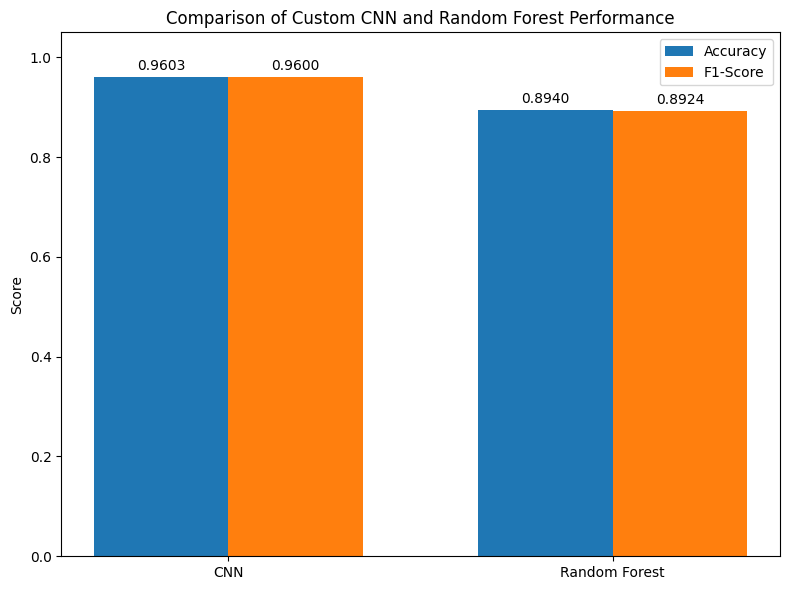

CNN vs Random Forest performance plot saved to cnn_rf_comparison.png


In [39]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cnn_rf_comparison(cnn_results, rf_results, output_path='cnn_rf_comparison.png'):
    """
    Generates a bar graph comparing the performance metrics (Accuracy and F1-Score)
    of a Custom CNN and a Random Forest model.

    Args:
        cnn_results (dict): Dictionary containing the evaluation results of the CNN.
                             Expected keys: 'accuracy', 'f1'.
        rf_results (dict): Dictionary containing the evaluation results of the Random Forest.
                            Expected keys: 'accuracy', 'f1'.
        output_path (str, optional): Path to save the generated plot.
                                     Defaults to 'cnn_rf_comparison.png'.
    """
    model_names = ['CNN', 'Random Forest']
    accuracy_scores = [cnn_results.get('accuracy', np.nan), rf_results.get('accuracy', np.nan)]
    f1_scores = [cnn_results.get('f1', np.nan), rf_results.get('f1', np.nan)]

    x = np.arange(len(model_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 6))
    rects1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy')
    rects2 = ax.bar(x + width/2, f1_scores, width, label='F1-Score')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Score')
    ax.set_title('Comparison of Custom CNN and Random Forest Performance')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()
    ax.set_ylim(0, 1.05) # Set y-axis limit for better visualization of scores (0 to 1)

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, indicating its height."""
        for rect in rects:
            height = rect.get_height()
            if not np.isnan(height):
                ax.annotate(f'{height:.4f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.savefig(output_path)
    plt.show()

# Example usage (assuming you have the 'individual_results' dictionary):
if __name__ == "__main__":
    # Assume 'individual_results' dictionary is populated after evaluating models
    individual_results = {
        'VGG19': {'accuracy': 0.85, 'f1': 0.83},
        'DenseNet': {'accuracy': 0.92, 'f1': 0.91},
        'CustomCNN': {'accuracy': 0.9603, 'f1': 0.9600},
        'ResNet50': {'accuracy': 0.88, 'f1': 0.87},
        'RandomForest': {'accuracy': 0.8940, 'f1': 0.8924},
        'SVM': {'accuracy': 0.78, 'f1': 0.75}
    }

    if 'CustomCNN' in individual_results and 'RandomForest' in individual_results:
        cnn_results = individual_results['CustomCNN']
        rf_results = individual_results['RandomForest']
        plot_cnn_rf_comparison(cnn_results, rf_results, output_path='cnn_rf_comparison.png')
        print("CNN vs Random Forest performance plot saved to cnn_rf_comparison.png")
    else:
        print("Could not find results for both Custom CNN and Random Forest in individual_results.")

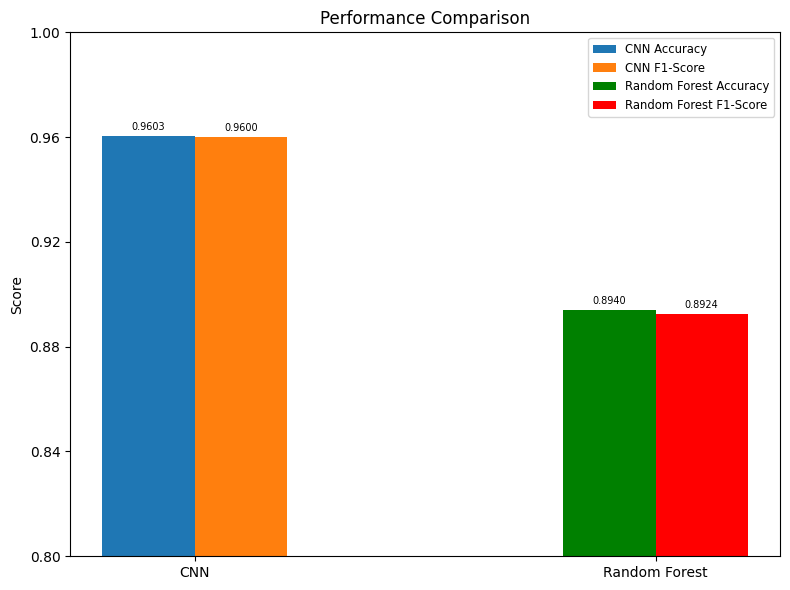

CNN vs Random Forest performance plot with adjusted y-axis scale saved to cnn_rf_comparison_simplified_grouped.png


In [35]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cnn_rf_comparison_simplified_y_grouped(cnn_results, rf_results, output_path='cnn_rf_comparison_simplified_grouped.png'):
    """
    Generates a grouped bar graph comparing Accuracy and F1-Score
    of a Custom CNN and a Random Forest model with a simplified y-axis.
    """
    model_names = ['CNN', 'Random Forest']
    metrics = ['Accuracy', 'F1-Score']
    cnn_accuracy = cnn_results.get('accuracy', np.nan)
    cnn_f1 = cnn_results.get('f1', np.nan)
    rf_accuracy = rf_results.get('accuracy', np.nan)
    rf_f1 = rf_results.get('f1', np.nan)

    x = np.arange(len(model_names)) * 2  # Increased spacing between groups
    group_width = 0.8
    bar_width = group_width / len(metrics)
    index = np.arange(len(model_names)) * 2 # Adjusted index for spacing

    fig, ax = plt.subplots(figsize=(8, 6)) # Increased figure size for better visualization

    # CNN bars
    cnn_accuracy_pos = index[0] - group_width / 2 + bar_width / 2
    rects1 = ax.bar(cnn_accuracy_pos, [cnn_accuracy], bar_width, label='CNN Accuracy')
    cnn_f1_pos = index[0] - group_width / 2 + bar_width * 1.5
    rects2 = ax.bar(cnn_f1_pos, [cnn_f1], bar_width, label='CNN F1-Score')

    # Random Forest bars with specified colors
    rf_accuracy_pos = index[1] - group_width / 2 + bar_width / 2
    rects3 = ax.bar(rf_accuracy_pos, [rf_accuracy], bar_width, color='green', label='Random Forest Accuracy')
    rf_f1_pos = index[1] - group_width / 2 + bar_width * 1.5
    rects4 = ax.bar(rf_f1_pos, [rf_f1], bar_width, color='red', label='Random Forest F1-Score')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Score')
    ax.set_title('Performance Comparison')
    ax.set_xticks(index)
    ax.set_xticklabels(model_names)
    ax.legend(fontsize='small')

    ax.set_ylim(0.80, 1.00)
    ax.set_yticks(np.arange(0.80, 1.01, 0.04))

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, indicating its height."""
        for rect in rects:
            height = rect.get_height()
            if not np.isnan(height):
                ax.annotate(f'{height:.4f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=7)

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)

    fig.tight_layout()
    plt.savefig(output_path)
    plt.show()

if __name__ == "__main__":
    individual_results = {
        'VGG19': {'accuracy': 0.85, 'f1': 0.83},
        'DenseNet': {'accuracy': 0.92, 'f1': 0.91},
        'CustomCNN': {'accuracy': 0.9603, 'f1': 0.9600},
        'ResNet50': {'accuracy': 0.88, 'f1': 0.87},
        'RandomForest': {'accuracy': 0.8940, 'f1': 0.8924},
        'SVM': {'accuracy': 0.78, 'f1': 0.75}
    }

    if 'CustomCNN' in individual_results and 'RandomForest' in individual_results:
        cnn_results = individual_results['CustomCNN']
        rf_results = individual_results['RandomForest']
        plot_cnn_rf_comparison_simplified_y_grouped(cnn_results, rf_results, output_path='cnn_rf_comparison_simplified_grouped.png')
        print("CNN vs Random Forest performance plot with adjusted y-axis scale saved to cnn_rf_comparison_simplified_grouped.png")
    else:
        print("Could not find results for both Custom CNN and Random Forest in individual_results.")

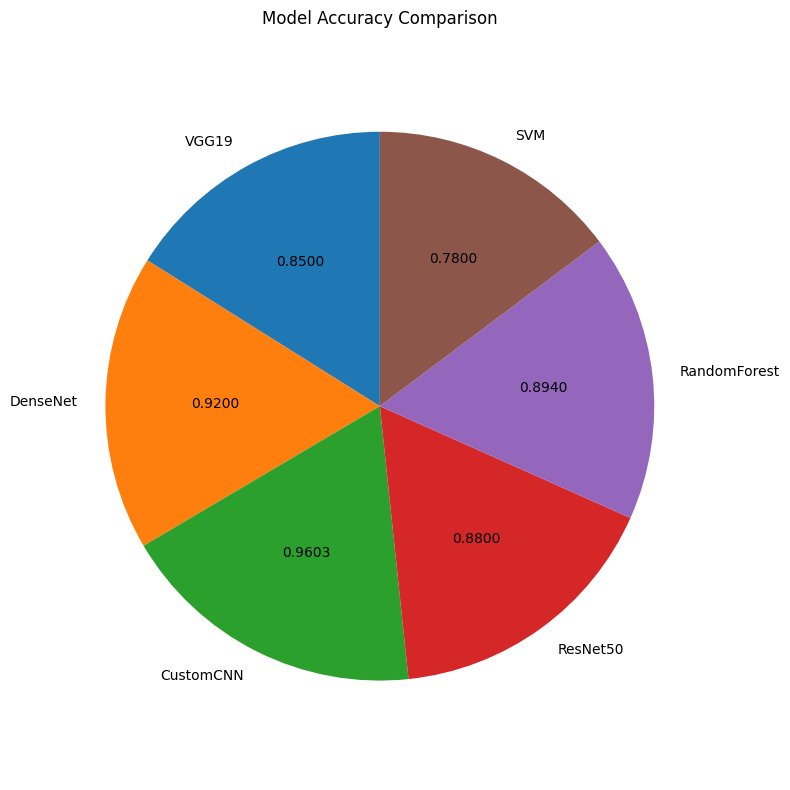

Model accuracy pie chart with accuracy values inside saved to model_accuracies_pie.png


In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_accuracies_pie(model_accuracies, output_path='model_accuracies_pie.png'):
    """
    Generates a pie chart visualizing the accuracies of different models
    with accuracy values displayed inside each slice.

    Args:
        model_accuracies (dict): Dictionary containing model names as keys
                                 and their corresponding accuracy scores as values.
        output_path (str, optional): Path to save the generated plot.
                                     Defaults to 'model_accuracies_pie.png'.
    """

    labels = list(model_accuracies.keys())
    sizes = list(model_accuracies.values())

    fig, ax = plt.subplots(figsize=(8, 8))

    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = pct * total / 100.0
            return f'{val:.4f}'
        return my_autopct

    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct=make_autopct(sizes), startangle=90,
                                      textprops={'fontsize': 10}) # Adjust fontsize as needed
    ax.set_title('Model Accuracy Comparison')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    fig.tight_layout()
    plt.savefig(output_path)
    plt.show()

if __name__ == "__main__":
    individual_results = {
        'VGG19': {'accuracy': 0.85, 'f1': 0.83},
        'DenseNet': {'accuracy': 0.92, 'f1': 0.91},
        'CustomCNN': {'accuracy': 0.9603, 'f1': 0.9600},
        'ResNet50': {'accuracy': 0.88, 'f1': 0.87},
        'RandomForest': {'accuracy': 0.8940, 'f1': 0.8924},
        'SVM': {'accuracy': 0.78, 'f1': 0.75}
    }

    # Extract accuracy for each model
    model_accuracies = {model: results['accuracy'] for model, results in individual_results.items()}

    plot_model_accuracies_pie(model_accuracies, output_path='model_accuracies_pie.png')
    print("Model accuracy pie chart with accuracy values inside saved to model_accuracies_pie.png")